<a href="https://colab.research.google.com/github/Alexkkir/face-points-detection/blob/main/cv_hw3_face_points_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
https://github.com/SlinkoIgor/Neural_Networks_and_CV/blob/master/module06_cifar.ipynb
https://github.com/Lornatang/AlexNet-PyTorch/blob/main/model.py

In [79]:
from IPython.display import clear_output

In [95]:
! apt install tree
! pip install pytorch_lightning
clear_output()

In [191]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import albumentations as A
import cv2

import numpy as np
import pandas as pd
from skimage import io, transform
import matplotlib
import matplotlib.pyplot as plt

import shutil
import requests
import functools
import pathlib
from pathlib import Path
import shutil
from tqdm.auto import tqdm
import os


matplotlib.rcParams['figure.figsize'] = (20, 5)

In [ ]:
# Alternative
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [185]:
# Get TensorBoard running in the background.
# Inspired by this answer.
LOG_DIR = 'lightning_logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [184]:
# ! killall tensorboard

In [157]:
# Download and unzip ngrok
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
! ./ngrok authtoken 2Guo3eQeUVGdSqqedxD6ZQD0dUh_2i3S4pzGLhvSCHJo3ojTQ
clear_output()

In [180]:
# Launch ngrok background process
get_ipython().system_raw('./ngrok http 6006 &')

In [181]:
# retrieve public url.
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://7525-34-171-74-112.ngrok.io


In [4]:
url = "https://fall.cv-gml.ru/task_file/12/public_tests"
file = "data.zip"

In [5]:
import requests

cookies = {
    'session': '.eJwlzjFqBDEMheG7uE5hyRpL2ssMkiWREEhgZrcKuXsMaV7xF4_vp5115f3eHs_rlW_t_Ij2aEAqc4g5kpoYRXiVTZjkHQ8HSQCNKNY8AA6ChZCdhkvmjOo6iWzWRNeOVkBRAxAVBhKWwjJnFkQZonsnrN55qSIMc_dqG_K68_rXINMO677qfH5_5tdOWyQMuiEpixlGZzXwfXIQZfTkERAz2u8fxcI-Xg.Y1z7MA.IlLtKJ5SwECajQaH8UOrgYzg1GU',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru,en;q=0.9',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # 'Cookie': 'session=.eJwlzjFqBDEMheG7uE5hyRpL2ssMkiWREEhgZrcKuXsMaV7xF4_vp5115f3eHs_rlW_t_Ij2aEAqc4g5kpoYRXiVTZjkHQ8HSQCNKNY8AA6ChZCdhkvmjOo6iWzWRNeOVkBRAxAVBhKWwjJnFkQZonsnrN55qSIMc_dqG_K68_rXINMO677qfH5_5tdOWyQMuiEpixlGZzXwfXIQZfTkERAz2u8fxcI-Xg.Y1z7MA.IlLtKJ5SwECajQaH8UOrgYzg1GU',
    'Referer': 'https://fall.cv-gml.ru/login',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.167 YaBrowser/22.7.5.933 Yowser/2.5 Safari/537.36',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Yandex";v="22"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Linux"',
}

response = requests.get('https://fall.cv-gml.ru/course/35/info', cookies=cookies, headers=headers)

In [6]:
def download(url, filename, **kwargs):    
    r = requests.get(url, **kwargs, stream=True, allow_redirects=True)
    if r.status_code != 200:
        r.raise_for_status()  # Will only raise for 4xx codes, so...
        raise RuntimeError(f"Request to {url} returned status code {r.status_code}")
    file_size = int(r.headers.get('Content-Length', 0))

    path = pathlib.Path(filename).expanduser().resolve()
    path.parent.mkdir(parents=True, exist_ok=True)

    desc = "(Unknown total file size)" if file_size == 0 else ""
    r.raw.read = functools.partial(r.raw.read, decode_content=True)  # Decompress if needed
    with tqdm.wrapattr(r.raw, "read", total=file_size, desc=desc) as r_raw:
        with path.open("wb") as f:
            shutil.copyfileobj(r_raw, f)

    return path

In [7]:
download(url, file, cookies=cookies, headers=headers)

  0%|          | 0/265024038 [00:00<?, ?it/s]

PosixPath('/content/data.zip')

In [8]:
shutil.unpack_archive('data.zip', 'data')

In [9]:
! tree data -aL 3

data
├── 00_test_img_gt
│   ├── gt.csv
│   └── img_shapes.csv
└── 00_test_img_input
    ├── test
    │   └── images
    └── train
        ├── gt.csv
        └── images

6 directories, 3 files


In [10]:
DATA_ROOT = Path('data')
images_path = DATA_ROOT / '00_test_img_input' / 'train' / 'images'
points_path = DATA_ROOT / '00_test_img_input' / 'train' / 'gt.csv'

In [11]:
class FacePointsDataset(Dataset):
    def __init__(self, images_path: Path, points_path: Path, transform = None, return_name=False):
        self.images_path = images_path
        self.points_df = pd.read_csv(points_path)
        self.transform = transform
        self.return_name = return_name

    def __len__(self):
        return len(self.points_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.points_df.iloc[idx, 0]
        image = io.imread(str(self.images_path / image_name)).astype('float32') / 255
        if image.ndim == 2:
            image = np.dstack([image] * 3)
        points = self.points_df.iloc[idx, 1:].to_numpy().reshape(-1, 2).astype('float32')

        sample = dict(image=image, points=points)

        if self.transform:
            sample = self.transform(sample)
        if self.return_name:
            sample['name'] = image_name

        return sample

In [12]:
class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = output_size
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, points = sample['image'], sample['points']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        points = points * [new_w / w, new_h / h]
        return {'image': img, 'points': points}

class Crop:
    def __init__(self, output_size, mode='random'):
        assert isinstance(output_size, (int, tuple))
        assert isinstance(mode, str)
        assert mode in ['random', 'center']
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
        self.mode = mode


    def __call__(self, sample):
        image, points = sample['image'], sample['points']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if self.mode == 'random':
            pos_h, pos_w = \
                np.random.randint(0, h - new_h), np.random.randint(0, w - new_w)
        else:
            pos_h, pos_w = (h - new_h) // 2, (w - new_w) // 2

        image = image[
            pos_h: pos_h + new_h, 
            pos_w: pos_w + new_w]
        points = points - [pos_w, pos_h]
        return {'image': image, 'points': points}

class ToTensor:
    def __call__(self, sample):
        image, points = sample['image'], sample['points']
        image = torch.from_numpy(image).permute((2, 0, 1))
        points = points.astype('float32')
        return {'image': image, 'points': points}

In [192]:
def show_points(image, points):
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], c='r')

def show_points_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['points']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = torchvision.utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=20, marker='o', c='r')

        plt.title('Batch from dataloader')

def test_on_batch(model, loader):
    n = 8
    batch = next(iter(loader))
    device = next(model.parameters()).device
    preds = model(batch['image'].to(device)).cpu().detach()
    true = batch['points']
    images = batch['image']

    print(((true[:n] - preds[:n]) ** 2).mean())

    show_points_batch({'image': images[:n], 'points': preds[:n]})
    plt.title('Predicted')
    plt.show()

    show_points_batch({'image': images[:n], 'points': true[:n]})
    plt.title('Ground truth')
    plt.show()

def test_on_image(model, image):
    device = next(model.parameters()).device
    pred = model(image.unsqueeze(0).to(device)).cpu().detach()[0]
    show_points(np.zeros_like(image.permute(1, 2, 0)) + 1, pred)

In [15]:
def modify_dataset(images_path, points_path, dst_folder: Path, scale_size, crop_size):
    shutil.rmtree(dst_folder, ignore_errors=True)
    transforms = T.Compose([
        Rescale(scale_size),
        Crop(crop_size, mode='center'),
    ])

    dataset = FacePointsDataset(images_path, points_path, transforms, return_name=True)
    (dst_folder / 'images').mkdir(parents=True, exist_ok=True)
    df = {}
    for i, sample in tqdm(enumerate(dataset), total=len(dataset)):
        image = sample['image']
        points = sample['points']
        name = sample['name']
        io.imsave(dst_folder / 'images' / name, (image * 255).astype('uint8'))
        df[name] = points.flatten()
    df = pd.DataFrame(df).T
    df.to_csv(dst_folder / 'points.csv')

MODIFIED = Path('rescaled')
modify_dataset(images_path, points_path, MODIFIED, 108, 108)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [38]:
def split_dataset(folder, val_size):
    shutil.rmtree(folder / 'train', ignore_errors=True)
    shutil.rmtree(folder / 'val', ignore_errors=True)
    (folder / 'train').mkdir(parents=True, exist_ok=True)
    (folder / 'val').mkdir(parents=True, exist_ok=True)

    dataset = FacePointsDataset(folder / 'images', folder / 'points.csv', return_name=True)
    df_train, df_val = {}, {}
    for i, sample in tqdm(enumerate(dataset), total=len(dataset)):
        image = sample['image']
        points = sample['points']
        name = sample['name']
        if np.random.rand() < val_size:
            io.imsave(folder / 'val' / name, (image * 255).astype('uint8'))
            df_val[name] = points.flatten()
        else:
            io.imsave(folder / 'train' / name, (image * 255).astype('uint8'))
            df_train[name] = points.flatten()
    pd.DataFrame(df_train).T.to_csv(folder / 'points_train.csv')
    pd.DataFrame(df_val).T.to_csv(folder / 'points_val.csv')

split_dataset(MODIFIED, 0.2)

  0%|          | 0/6000 [00:00<?, ?it/s]

In [140]:
transforms = T.Compose([
    Crop(96),
    ToTensor(),
])

train_dataset = FacePointsDataset(MODIFIED / 'train', MODIFIED / 'points_train.csv', transform=transforms)
val_dataset = FacePointsDataset(MODIFIED / 'val', MODIFIED / 'points_val.csv', transform=transforms)

batch_size = 8
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dl_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [141]:
len(train_dataset), len(val_dataset)

(4809, 1191)

In [142]:
! ls rescaled/images | wc -l

6000


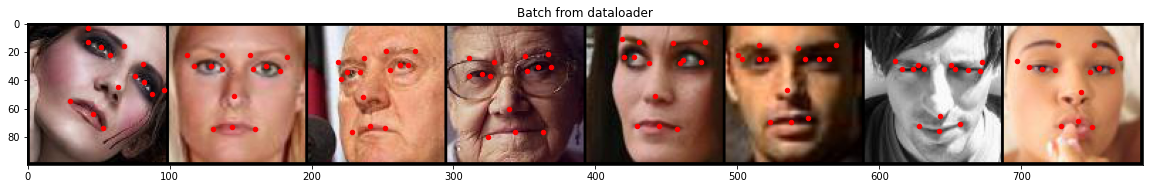

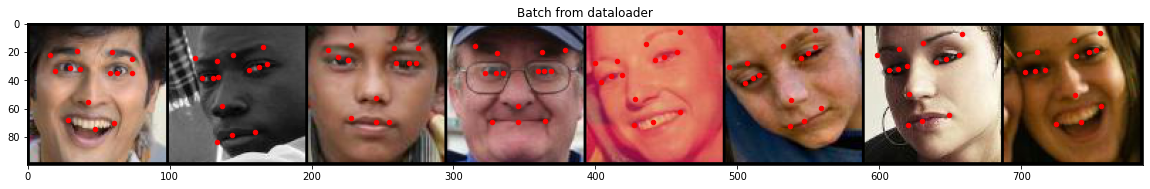

In [143]:
for i, batch in enumerate(dl_train):
    if i == 2:
        break
    show_points_batch(batch)
    plt.show()

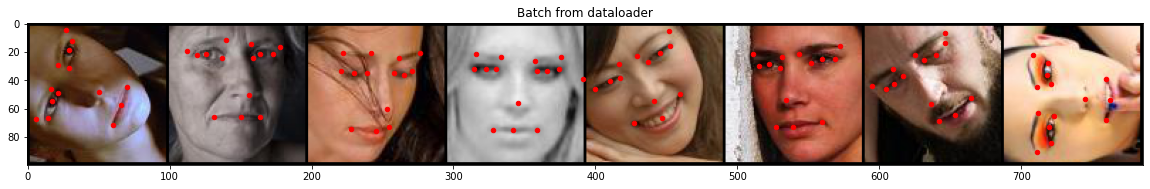

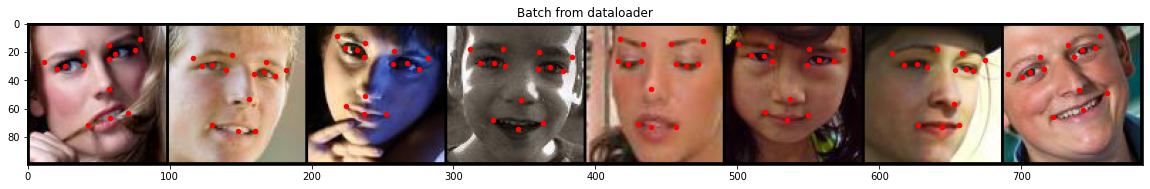

In [144]:
for i, batch in enumerate(dl_val):
    if i == 2:
        break
    show_points_batch(batch)
    plt.show()

In [151]:
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64,128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.mlp = nn.Sequential(
            nn.Linear(256 * 12 * 12, 64),
            nn.ReLU(),
            nn.Linear(64, 28)
        )

        self.loss = nn.MSELoss()
        self.acc = nn.L1Loss()

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)
        x = self.mlp(x)
        x = x.view(x.size(0), -1, 2)
        return x

    def training_step(self, batch, batch_idx):
        """the full training loop"""
        x, y = batch['image'], batch['points']
        
        pred = self(x)
        loss = self.loss(pred, y)
        acc = self.acc(pred, y)

        return {'loss': loss, 'acc': acc}

    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=5e-4)
        # optimizer = torch.optim.SGD(self.parameters(), lr=1e-3, momentum=0.9)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.2, 
            patience=5, 
            verbose=True)
        
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_acc"
        } 

        return [optimizer], [lr_dict]

    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch['image'], batch['points']

        pred = self(x)
        loss = self.loss(pred, y)
        acc = self.acc(pred, y)

        return {'val_loss': loss, 'val_acc': acc}

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()

        print(f"| Train_acc: {avg_acc:.2f}, Train_loss: {avg_loss:.2f}" )

        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        print(f"[Epoch {self.trainer.current_epoch:3}] Val_acc: {avg_acc:.2f}, Val_loss: {avg_loss:.2f}", end= " ")

        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

In [186]:
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_classifier',
                                    filename='{epoch}-{val_acc:.3f}',
                                    monitor='val_acc', 
                                    mode='max', 
                                    save_top_k=1)

MyEarlyStopping = EarlyStopping(monitor = "val_acc",
                                mode = "max",
                                patience = 4,
                                verbose = True)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    # callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=5 # dataset is quite small
)

model = Model()

trainer.fit(model, dl_train, dl_val)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params
------------------------------------
0 | cnn  | Sequential | 370 K 
1 | mlp  | Sequential | 2.4 M 
2 | loss | MSELoss    | 0     
3 | acc  | L1Loss     | 0     
-

Sanity Checking: 0it [00:00, ?it/s]

[Epoch   0] Val_acc: 40.39, Val_loss: 2051.39 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[Epoch   0] Val_acc: 4.99, Val_loss: 47.23 | Train_acc: 6.17, Train_loss: 82.68


Validation: 0it [00:00, ?it/s]

[Epoch   1] Val_acc: 4.44, Val_loss: 38.50 | Train_acc: 4.19, Train_loss: 36.56


Validation: 0it [00:00, ?it/s]

[Epoch   2] Val_acc: 7.32, Val_loss: 81.12 | Train_acc: 3.62, Train_loss: 29.74


Validation: 0it [00:00, ?it/s]

[Epoch   3] Val_acc: 4.02, Val_loss: 31.88 | Train_acc: 3.42, Train_loss: 26.62


Validation: 0it [00:00, ?it/s]

[Epoch   4] Val_acc: 3.18, Val_loss: 23.73 | Train_acc: 3.19, Train_loss: 23.93


Validation: 0it [00:00, ?it/s]

[Epoch   5] Val_acc: 2.80, Val_loss: 19.98 | Train_acc: 3.05, Train_loss: 22.02


Validation: 0it [00:00, ?it/s]

[Epoch   6] Val_acc: 2.74, Val_loss: 18.86 | Train_acc: 3.02, Train_loss: 21.79


Validation: 0it [00:00, ?it/s]

[Epoch   7] Val_acc: 2.89, Val_loss: 20.04 | Train_acc: 2.93, Train_loss: 20.54


Validation: 0it [00:00, ?it/s]

[Epoch   8] Val_acc: 3.22, Val_loss: 22.02 | Train_acc: 2.86, Train_loss: 18.89
Epoch 00009: reducing learning rate of group 0 to 2.0000e-04.


Validation: 0it [00:00, ?it/s]

[Epoch   9] Val_acc: 2.49, Val_loss: 15.48 | Train_acc: 2.48, Train_loss: 15.42


Validation: 0it [00:00, ?it/s]

[Epoch  10] Val_acc: 2.44, Val_loss: 14.90 | Train_acc: 2.45, Train_loss: 14.76


Validation: 0it [00:00, ?it/s]

[Epoch  11] Val_acc: 2.78, Val_loss: 17.62 | Train_acc: 2.46, Train_loss: 14.55


Validation: 0it [00:00, ?it/s]

[Epoch  12] Val_acc: 2.96, Val_loss: 18.68 | Train_acc: 2.42, Train_loss: 14.06


Validation: 0it [00:00, ?it/s]

[Epoch  13] Val_acc: 2.76, Val_loss: 16.75 | Train_acc: 2.41, Train_loss: 13.72


Validation: 0it [00:00, ?it/s]

[Epoch  14] Val_acc: 2.60, Val_loss: 14.61 | Train_acc: 2.42, Train_loss: 13.64
Epoch 00015: reducing learning rate of group 0 to 4.0000e-05.


Validation: 0it [00:00, ?it/s]

[Epoch  15] Val_acc: 2.37, Val_loss: 13.56 | Train_acc: 2.29, Train_loss: 12.43


Validation: 0it [00:00, ?it/s]

[Epoch  16] Val_acc: 2.38, Val_loss: 13.51 | Train_acc: 2.27, Train_loss: 12.15


Validation: 0it [00:00, ?it/s]

[Epoch  17] Val_acc: 2.35, Val_loss: 12.81 | Train_acc: 2.29, Train_loss: 12.20


Validation: 0it [00:00, ?it/s]

[Epoch  18] Val_acc: 2.35, Val_loss: 13.24 | Train_acc: 2.29, Train_loss: 12.21


Validation: 0it [00:00, ?it/s]

[Epoch  19] Val_acc: 2.36, Val_loss: 13.18 | Train_acc: 2.27, Train_loss: 11.89


Validation: 0it [00:00, ?it/s]

[Epoch  20] Val_acc: 2.31, Val_loss: 12.57 | Train_acc: 2.28, Train_loss: 11.99
Epoch 00021: reducing learning rate of group 0 to 8.0000e-06.


Validation: 0it [00:00, ?it/s]

[Epoch  21] Val_acc: 2.36, Val_loss: 13.00 | Train_acc: 2.25, Train_loss: 11.65


Validation: 0it [00:00, ?it/s]

[Epoch  22] Val_acc: 2.33, Val_loss: 12.89 | Train_acc: 2.26, Train_loss: 11.67


Validation: 0it [00:00, ?it/s]

[Epoch  23] Val_acc: 2.32, Val_loss: 12.33 | Train_acc: 2.24, Train_loss: 11.56


Validation: 0it [00:00, ?it/s]

[Epoch  24] Val_acc: 2.35, Val_loss: 12.90 | Train_acc: 2.25, Train_loss: 11.73


Validation: 0it [00:00, ?it/s]

[Epoch  25] Val_acc: 2.33, Val_loss: 12.37 | Train_acc: 2.23, Train_loss: 11.42


Validation: 0it [00:00, ?it/s]

[Epoch  26] Val_acc: 2.36, Val_loss: 13.03 | Train_acc: 2.25, Train_loss: 11.60
Epoch 00027: reducing learning rate of group 0 to 1.6000e-06.


Validation: 0it [00:00, ?it/s]

[Epoch  27] Val_acc: 2.35, Val_loss: 12.75 | Train_acc: 2.23, Train_loss: 11.15


Validation: 0it [00:00, ?it/s]

[Epoch  28] Val_acc: 2.35, Val_loss: 13.34 | Train_acc: 2.22, Train_loss: 11.28


Validation: 0it [00:00, ?it/s]

[Epoch  29] Val_acc: 2.33, Val_loss: 12.44 | Train_acc: 2.22, Train_loss: 11.33


Validation: 0it [00:00, ?it/s]

[Epoch  30] Val_acc: 2.31, Val_loss: 12.07 | Train_acc: 2.23, Train_loss: 11.36


Validation: 0it [00:00, ?it/s]

[Epoch  31] Val_acc: 2.32, Val_loss: 12.50 | Train_acc: 2.24, Train_loss: 11.45


Validation: 0it [00:00, ?it/s]

[Epoch  32] Val_acc: 2.33, Val_loss: 12.97 | Train_acc: 2.23, Train_loss: 11.41
Epoch 00033: reducing learning rate of group 0 to 3.2000e-07.


Validation: 0it [00:00, ?it/s]

[Epoch  33] Val_acc: 2.32, Val_loss: 12.18 | Train_acc: 2.21, Train_loss: 11.07


Validation: 0it [00:00, ?it/s]

[Epoch  34] Val_acc: 2.30, Val_loss: 11.98 | Train_acc: 2.24, Train_loss: 11.60


Validation: 0it [00:00, ?it/s]

[Epoch  35] Val_acc: 2.35, Val_loss: 12.69 | Train_acc: 2.23, Train_loss: 11.30


Validation: 0it [00:00, ?it/s]

[Epoch  36] Val_acc: 2.34, Val_loss: 12.80 | Train_acc: 2.24, Train_loss: 11.33


Validation: 0it [00:00, ?it/s]

[Epoch  37] Val_acc: 2.35, Val_loss: 12.84 | Train_acc: 2.22, Train_loss: 11.21


Validation: 0it [00:00, ?it/s]

[Epoch  38] Val_acc: 2.32, Val_loss: 12.42 | Train_acc: 2.24, Train_loss: 11.22
Epoch 00039: reducing learning rate of group 0 to 6.4000e-08.


Validation: 0it [00:00, ?it/s]

[Epoch  39] Val_acc: 2.34, Val_loss: 12.48 | Train_acc: 2.23, Train_loss: 11.25


Validation: 0it [00:00, ?it/s]

[Epoch  40] Val_acc: 2.33, Val_loss: 13.35 | Train_acc: 2.23, Train_loss: 11.26


Validation: 0it [00:00, ?it/s]

[Epoch  41] Val_acc: 2.33, Val_loss: 12.57 | Train_acc: 2.24, Train_loss: 11.29


Validation: 0it [00:00, ?it/s]

[Epoch  42] Val_acc: 2.33, Val_loss: 12.42 | Train_acc: 2.22, Train_loss: 11.15


Validation: 0it [00:00, ?it/s]

[Epoch  43] Val_acc: 2.33, Val_loss: 12.16 | Train_acc: 2.24, Train_loss: 11.44


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


tensor(6.6780)


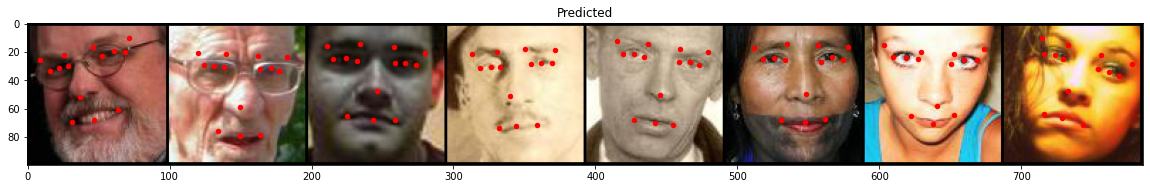

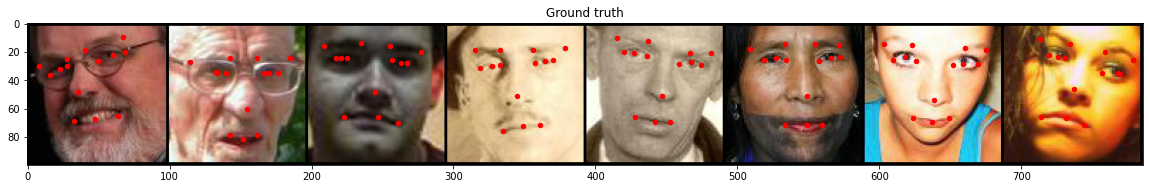

In [193]:
test_on_batch(model, dl_train)